# Preprocessing

In [19]:
# load packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [20]:
# data imported from https://www.kaggle.com/competitions/titanic/overview

df = pd.read_csv("data/test.csv")
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
df_original = df.copy()

In [22]:
# show information about variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [23]:
df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Exploratory Data Analysis (EDA)

- Plots to identify distributions
- check for NaNs
- Correlations
- we drop some variables, some are transformed and we get some new features

#### PassengerId
We drop the variable 'PassengerId' since it is just a index column and therefore does not give us any information about the survival of a passenger.

In [24]:
# PassengerId is a index column --> drop this variable
df.drop("PassengerId", inplace=True, axis=1)

#### Pclass
The numerical variable 'Pclass' indicates the ticket class and has values 1,2, and 3. Since it cannot take any other values,  we convert it to a categorical variable.  
Then we have a look at the distribution of 'Pclass'. We don't have any missing values.

Pclass
1    107
2     93
3    218
dtype: int64


<AxesSubplot: >

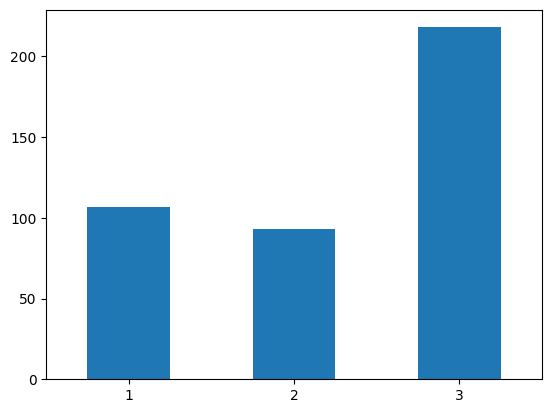

In [25]:
# change datatype from integer to object
df['Pclass'] = df['Pclass'].astype(object)

# distribution
print(df.groupby('Pclass').size())
df['Pclass'].value_counts().loc[[1,2,3]].plot(kind='bar', rot = 0)

#### Name
We extract the title of the passengers from the 'Name' column, map them to different integers and store them in the new column 'Title'. Then we drop the column 'Name'.

In [26]:
# retrieve title and create new column, drop name column

title_mapping = {
    "Mr": 'Mr',
    "Miss": 'Ms', "Mlle": 'Ms', "Ms": 'Ms',
    "Mrs": 'Mrs', "Mme": 'Mrs',
    "Master": 'Master',
    "Don": 'Noble', "Rev": 'Noble', "Dr": 'Noble', "Major": 'Noble', "Lady": 'Noble', "Sir": 'Noble', "Col": 'Noble', "Capt": 'Noble', "the Countess": 'Noble', "Jonkheer": 'Noble'
}

df["Title"] = 'None'
for idx, x in enumerate(df["Name"]):
    for s in x.split(" "):
        s = s.replace(".", "")
        if s in title_mapping.keys():
            df.loc[idx, 'Title'] = title_mapping[s]

# there is one female passenger without a title --> we assign 'Ms' as her title
df.loc[df['Title'] == "None", 'Title'] = 'Ms'

# drop the name column
df.drop("Name", inplace=True, axis=1)

<AxesSubplot: >

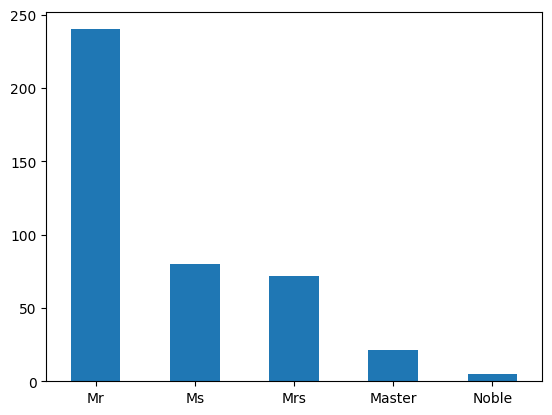

In [27]:
df['Title'].value_counts().plot(kind='bar', rot = 0)

#### Sex
We have a look at the distribution of 'Sex'. There are a lot more male than female passengers in our dataset.

Sex
female    152
male      266
dtype: int64


<AxesSubplot: >

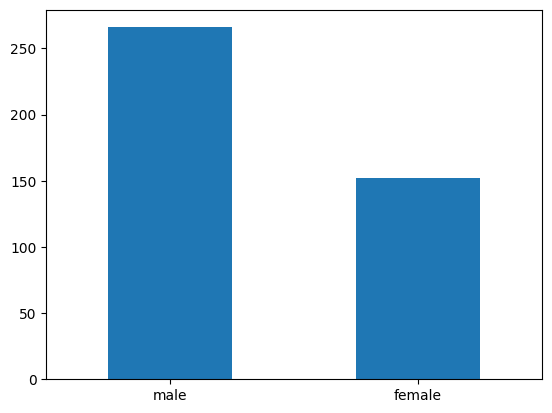

In [28]:
# plot the numbers of female and male passengers
print(df.groupby('Sex').size())
df["Sex"].value_counts().plot(kind = "bar", rot = 0)

#### Age
- The age is fractional if less than 1. We transform those ages to 0.  
- If the age is estimated, it is in the form of xx.5 --> We build a new column 'Age_true' which indicates if the age is true or estimated. Then we transform the estimated ages in the form of xx.5 into the form xx (that is we remove the fractional)  
- There are 177 passengers without any information about their age. --> We estimate their ages as follows and consider their ages to be estimated: For each title group we calculate the mean age (only using the train data). Then for each passenger without information about the age, we assign the mean age of the corresponding title group.  
- We bin the ages: We form a new column 'AgeGroup' where the passengers are assigned to different groups according to their age. Those groups are: Kids (0-11), Teenagers (12-17), Young Adults (18-24), Adults (25-34), Middle-aged (35-49), Seniors (49+). We chose that split such that the passengers are distributed equally (more or less) about the different age groups.

Note: For replacing the NaNs, we determine the mean ages of all title groups. For this, we only use the train data. Therefore, we already split the data here into train and test data. We perform all feature engineering and EDA on the whole data set and only use the split here for determining the replacing values. After this, we go on with the whole data set and perform the train test split again when we finished the preprocessing.

In [29]:
# check for NaNs
len(df[df.Age.isna()])

86

In [30]:
# new column 'Age_true' (False if age not known or estimated)
df['Age_true'] = True
df.loc[((df['Age'] % 1 != 0) & (df['Age'] >= 1)) | (df['Age'].isna()), 'Age_true'] = False
len(df[df.Age_true == False])

101

In [31]:
# if age<1, transform to age=0 AND if age estimated, use estimated age as true age (remove fractional)
df['Age'] = df['Age'] - df['Age']%1

In [32]:
# split the data set into train and test data to determine the mean ages based on the train data
X_test = df
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df.drop("Survived", axis=1), df["Survived"], test_size=0.3, random_state=42, shuffle=True)

In [34]:
# replace NaNs: we use the mean age according to the column 'Title' (determined on the training data) - Option 1

# save 'Age' column for Option 2
df['Age_Opt2'] = df['Age'] # for Option 2

# Option 1: replacing by an exact age
# for each category in 'Title', find the mean age, then assign this mean to the passengers without age
# we only use the train data to determine the values with which we replace the NaNs
mean_ages = X_test.groupby('Title')['Age'].agg(np.mean).round()
print(mean_ages)
df.loc[df['Age'].isna(), 'Age'] = df.apply(lambda x: mean_ages[x['Title']], axis=1)

Title
Master     7.0
Mr        32.0
Mrs       39.0
Ms        22.0
Noble     45.0
Name: Age, dtype: float64


In [35]:
# assigning the age groups
# old split: age_bins = [-1, 11, 17, 29, 49, 64]
age_bins = [-1, 11, 17, 24, 34, 49]
age_groups = ["Kids", "Teenagers", "Young Adults", "Adults", "Middle-aged", "Seniors"]

for i in range(len(age_groups) - 1):
    df.loc[(df["Age"] > age_bins[i]) & (df["Age"] <= age_bins[i+1]), "AgeGroup"] = age_groups[i]
df.loc[df["Age"] > age_bins[len(age_groups) - 1], "AgeGroup"] = age_groups[len(age_groups) - 1]

In [36]:
# Option 2 - not used

# replace NaNs: we use the mean age according to the column 'Title' - Option 2

# we first assign the age groups, then we replace the NaNs
age_bins = [-1, 11, 17, 24, 34, 49]
age_groups = ["Kids", "Teenagers", "Young Adults", "Adults", "Middle-aged", "Seniors"]

for i in range(len(age_groups) - 1):
    df.loc[(df["Age_Opt2"] > age_bins[i]) & (df["Age_Opt2"] <= age_bins[i+1]), "AgeGroup_Opt2"] = age_groups[i]
df.loc[df["Age_Opt2"] > age_bins[len(age_groups) - 1], "AgeGroup_Opt2"] = age_groups[len(age_groups) - 1]

# Option 2: replacing by an age group
# for each category in 'Title', find the age group that is represented most often, then assign this group to the passenger
mean_agegroups = df.groupby('Title')['AgeGroup_Opt2'].agg(pd.Series.mode)
df.loc[df['AgeGroup_Opt2'].isna(), 'AgeGroup_Opt2'] = df.apply(lambda x: mean_agegroups[x['Title']], axis=1)

Reminder: The plots for Age_Opt2 (second and sixth plot) do not contain the replaced ages (NaNs are just left out)


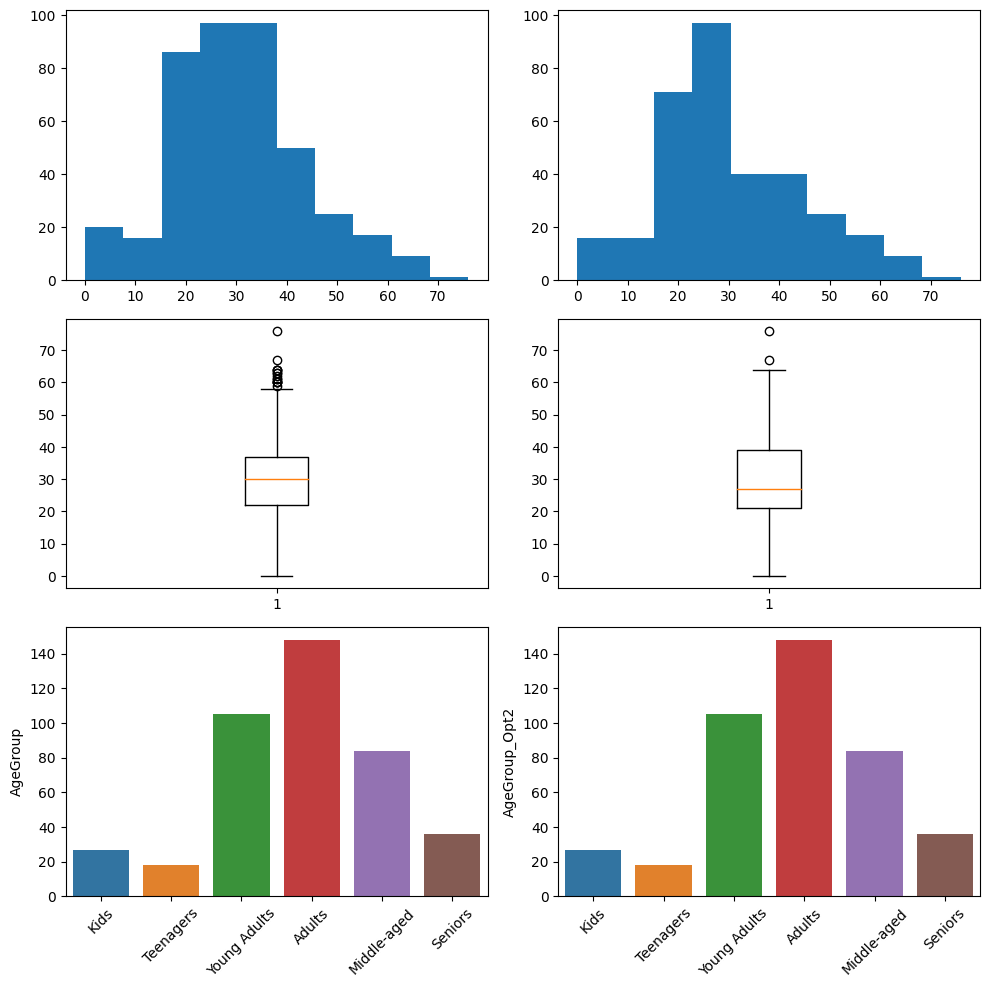

In [37]:
# plot 'Age' and 'AgeGroup' (also for Option 2)

# define a figure with sub plots so we can compare different histograms
# the parameters are: number of rows, number of columns, share the y-axis, and the size of the figure
fig, axs = plt.subplots(3, 2, sharey=False, figsize=(10,10))

# plot a histogram of column 'Age'
axs[0][0].hist(df['Age'])
# plot a histogram of column 'Age_Opt2' (contains NaNs)
axs[0][1].hist(df['Age_Opt2'])
# plot a boxplot of column 'Age'
axs[1][0].boxplot(df['Age'])
# plot a boxplot of column 'Age_Opt2' (remove NaNs)
axs[1][1].boxplot(df[df['Age_Opt2'].isna() == False]['Age_Opt2'])
# plot a barplot of column 'AgeGroup'
sns.barplot(ax = axs[2][0], x = df['AgeGroup'].unique(), y = df["AgeGroup"].value_counts(sort=False), order = age_groups)
axs[2][0].set_xticklabels(age_groups, rotation = 45)
# plot a barplot of column 'AgeGroup_Opt2'
sns.barplot(ax = axs[2][1], x = df['AgeGroup_Opt2'].unique(), y = df["AgeGroup_Opt2"].value_counts(sort=False), order = age_groups)
axs[2][1].set_xticklabels(age_groups, rotation = 45)

# use this call to prevent the subplots from overlapping
plt.tight_layout()
# print reminder
print("Reminder: The plots for Age_Opt2 (second and sixth plot) do not contain the replaced ages (NaNs are just left out)")
# show the figure
plt.show()

# plot without matplotlib
#df["AgeGroup"].value_counts().plot(kind = "bar")

#### SibSp & Parch
We plot 'SibSp' and 'Parch'.  
We build a new column 'Familysize' adding 'SibSp' and 'Parch'.  
We will compute the correlations later to check which of the three columns we should keep and which we should drop.
Reminder: If Parch=0, this can also mean that the children traveled with a nanny.

In [38]:
# familze size is simplified by adding siblings and parents
df['Familysize'] = df['SibSp'] + df['Parch']
df['Familysize'] = df['Familysize'].astype(int)

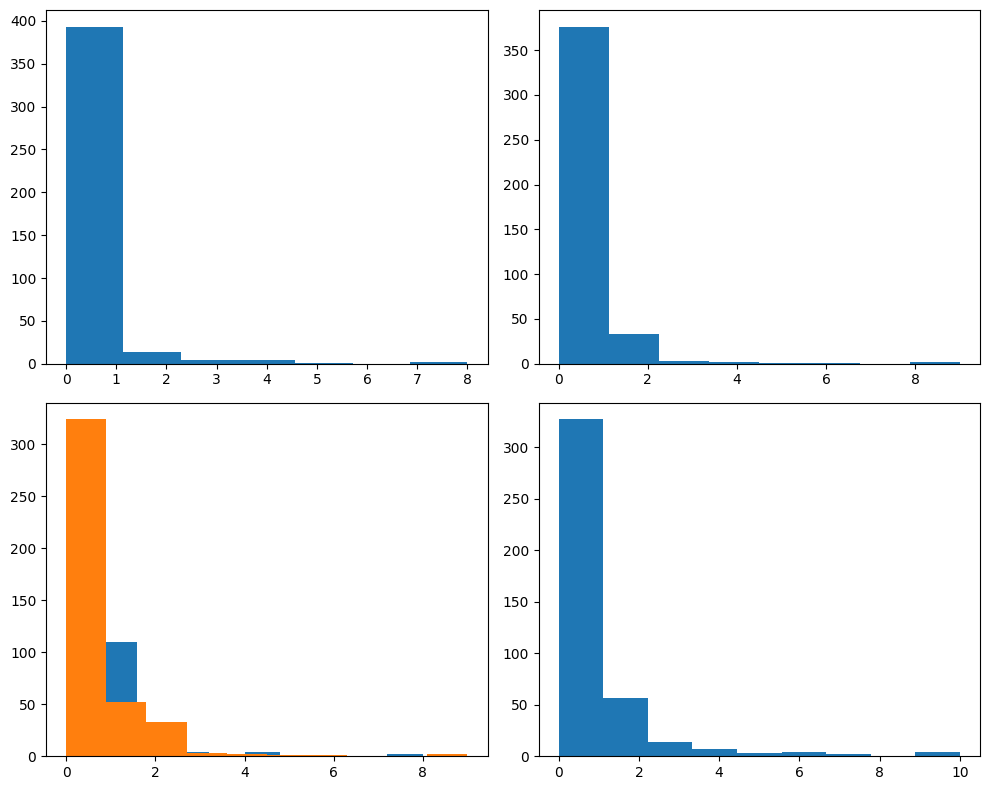

In [39]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(10,8))

# plot a histogram of column 'SibSp'
axs[0][0].hist(df['SibSp'], bins=df['SibSp'].max()-1)
# plot a histogram of column 'Parch'
axs[0][1].hist(df['Parch'], bins=df['Parch'].max()-1)
# plot both histograms in one plot
axs[1][0].hist(df['SibSp'])
axs[1][0].hist(df['Parch'])
# plot a histogram of colum 'Familysize'
axs[1][1].hist(df['Familysize'], bins=df['Familysize'].max()-1)

plt.tight_layout()
plt.show()

In [40]:
# check how many passengers have 'Familysize'>0
len(df[df['Familysize'] > 0])

165

#### Ticket

We add a column 'Ticketsize' which indicates how many people have the same ticket. We consider these passengers as travel companions. Then we drop the column 'Ticket'.  
There are 4 passengers with the ticket "LINE". Those ones are not considered as traveling together and therefore get Ticketsize=1.  
We also check if the Ticketsize matches with the Familysize.

In [41]:
# there are 4 passengers with Ticket=="LINE"
df[df['Ticket'] == "LINE"]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_true,Age_Opt2,AgeGroup,AgeGroup_Opt2,Familysize


In [42]:
# we add a column 'Ticketsize' which indicates how many people are assigned to the respective ticket
# we assume that people who have the same ticket, travel together
ticket_grouped = df.groupby('Ticket')
df['Ticketsize'] = 1

for ticket, group in ticket_grouped:
    if len(group) > 1:
        df.loc[df['Ticket'] == ticket, 'Ticketsize'] = len(group)
df.loc[df['Ticket'] == "LINE", 'Ticketsize'] = 1

# we don't drop the column 'Ticket' yet but wait until we finished our analysis on 'Fare'
#df.drop("Ticket", inplace=True, axis=1)

(array([321.,  66.,  18.,  13.]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

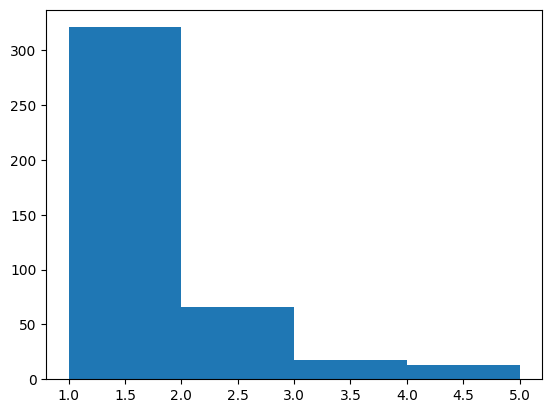

In [43]:
plt.hist(df['Ticketsize'], bins=df['Ticketsize'].max()-1)

In [44]:
# compare 'Ticketsize' and 'Familysize'
df['SizeEqual'] = (df['Familysize'] == (df['Ticketsize'] - 1))
len(df[df['SizeEqual'] == False])
# Familysize and Ticketsize-1 are not equal for 284 passengers

155

In [45]:
# we drop column 'SizeEqual' since it only was for analyzing purposes and we don't need it for our prediction
df.drop("SizeEqual", inplace=True, axis=1)

#### Fare
We plot the distribution of 'Fare' (histogram and boxplot).  
We check if it's useful to group the fares together in order to deal with extremely high fares.  
There are 15 passengers that have Fare==0. For passengers with ticket "LINE", we keep Fare=0. For the other passengers we replace the value by the mean of the corresponding 'Pclass'.

In [46]:
# some tickets have Fare==0
df[df.Fare == 0]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_true,Age_Opt2,AgeGroup,AgeGroup_Opt2,Familysize,Ticketsize
266,1,male,32.0,0,0,112051,0.0,NaN,S,Mr,False,NaN,Adults,Adults,0,1
372,1,male,49.0,0,0,112058,0.0,B52 B54 B56,S,Mr,True,49.0,Middle-aged,Middle-aged,0,1


In [47]:
# we replace the fares which are 0 by the mean fare of the corresponding 'Pclass'
mean_fares = df.groupby('Pclass')['Fare'].agg(np.mean)
df.loc[(df['Fare'] == 0) & (df['Ticket'] != "LINE"), 'Fare'] = df.apply(lambda x: mean_fares[x['Pclass']], axis=1)

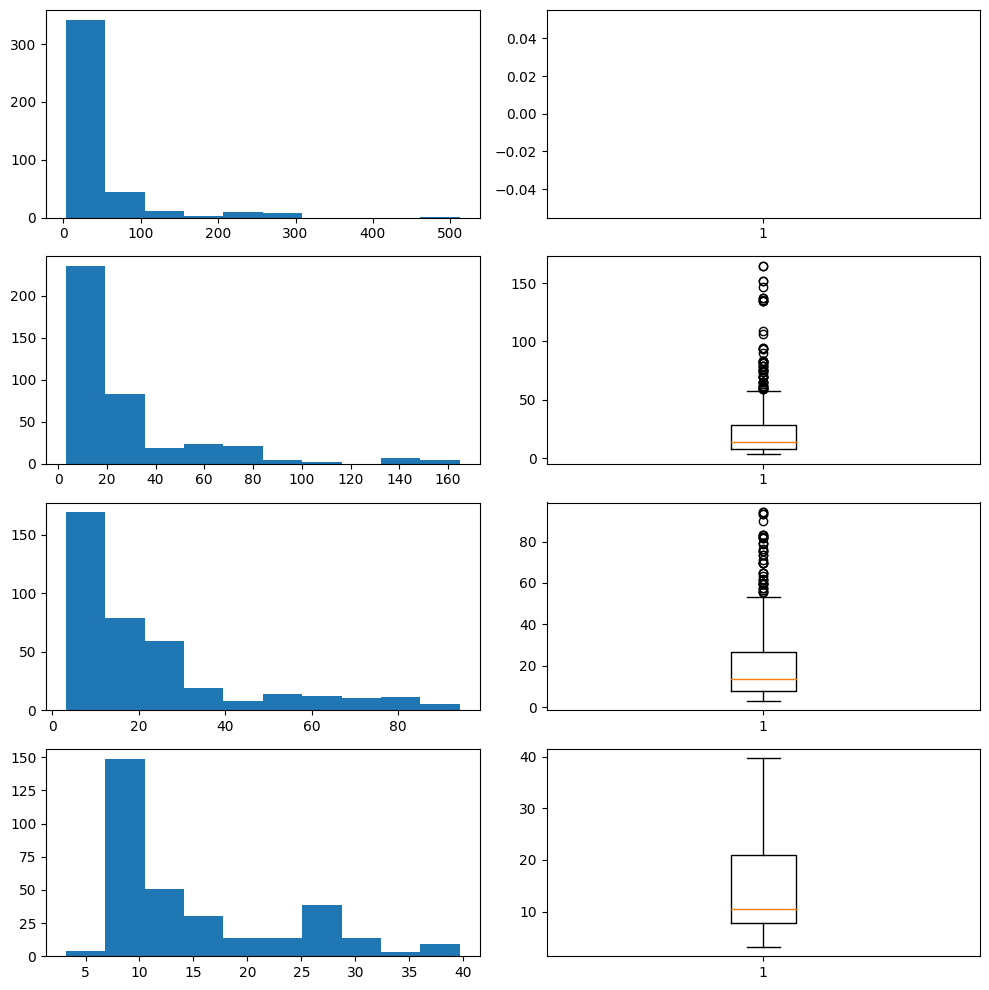

In [48]:
fig, axs = plt.subplots(4, 2, sharey=False, figsize=(10,10))

# plot a histogram of column 'Fare' for all fares
axs[0][0].hist(df['Fare'])
# plot a boxplot of column 'Fare' for all fares
axs[0][1].boxplot(df['Fare'])
# plot a histogram of column 'Fare' for fares below 200
axs[1][0].hist(df['Fare'][df['Fare'] < 200])
# plot a boxplot of column 'Fare' for fares below 200
axs[1][1].boxplot(df['Fare'][df['Fare'] < 200])
# plot a histogram of column 'Fare' for fares below 100
axs[2][0].hist(df['Fare'][df['Fare'] < 100])
# plot a boxplot of column 'Fare' for fares below 100
axs[2][1].boxplot(df['Fare'][df['Fare'] < 100])
# plot a histogram of column 'Fare' for fares below 40
axs[3][0].hist(df['Fare'][df['Fare'] < 40])
# plot a boxplot of column 'Fare' for fares below 40
axs[3][1].boxplot(df['Fare'][df['Fare'] < 40])

plt.tight_layout()
plt.show()

In [49]:
perc = [0.25, 0.5, 0.75, 0.8, 0.85, 0.87, 0.94, 0.95]
print(df['Fare'].describe(percentiles = perc))
print("med:", df['Fare'].median())

count    417.000000
mean      36.079372
std       55.999010
min        3.170800
25%        7.895800
50%       14.458300
75%       31.500000
80%       47.060000
85%       61.297520
87%       69.550000
94%      135.679136
95%      151.550000
max      512.329200
Name: Fare, dtype: float64
med: 14.4583


Although the fares range from 0 to 512.3, they have a mean of 32.8. 75% of the fares are smaller than 31.3, 85% are smaller than 56.7, and only 13% are larger than 70. The median is 14.5

In [50]:
# we group the fares
# the groups are chosen such that the distribution over the groups is more or lessen even
fare_bins = [-1, 7.8, 10.5, 23, 41, 100]
fare_groups = ["Very Cheap", "Cheap", "Normal", "Average", "Expensive", "Very Expensive"]

for i in range(len(fare_groups) - 1):
    df.loc[(df["Fare"] > fare_bins[i]) & (df["Fare"] <= fare_bins[i+1]), "FareGroup"] = fare_groups[i]
df.loc[df["Fare"] > fare_bins[len(fare_groups) - 1], "FareGroup"] = fare_groups[len(fare_groups) - 1]

<AxesSubplot: >

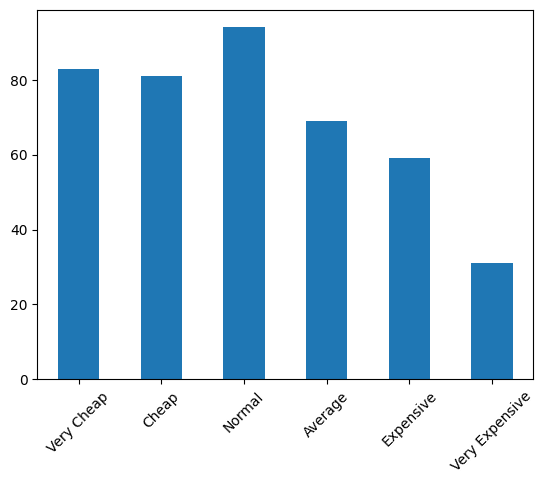

In [52]:
df['FareGroup'].value_counts().loc[["Very Cheap", "Cheap", "Normal", "Average", "Expensive", "Very Expensive"]].plot(kind='bar', rot = 45)

In [53]:
# now we drop the column 'Ticket'
df.drop("Ticket", inplace=True, axis=1)

#### Cabin
We extract the letter from the name of the cabin because it indicates the cabin level. We use this letter to form a new column 'CabinLvl'. Passengers that don't have any information about the cabin, get CabinLvl='XX'. Then we drop the column 'Cabin'.  
We will calculate the correlation with CabinLvl later to see if it's worth it to keep 'CabinLvl' since only 22.9% of the passengers have cabin information.

In [54]:
# Count NaN values for 'Cabin'
print(len(df[df['Cabin'].isna()]))
print((891-687)/891)

327
0.22895622895622897


In [55]:
# since most cabin numbers are not given, XX is assigned by default
df["CabinLvl"] = 'XX'
for idx, x in enumerate(df["Cabin"]):
    try:
        df.loc[idx, 'CabinLvl'] = x[0]
    except:
        pass

df.drop("Cabin", inplace=True, axis=1)

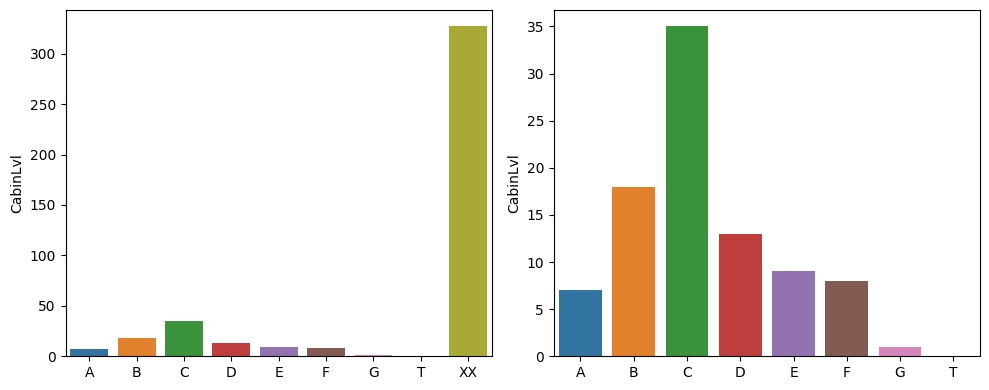

In [56]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10,4))

# plot a histogram of column 'CabinLvl'
sns.barplot(ax = axs[0], x = df['CabinLvl'].unique(), y = df["CabinLvl"].value_counts(sort=False), order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'XX'] )
# plot a histogram of column 'CabinLvl' without 'XX'
sns.barplot(ax = axs[1], x = df['CabinLvl'][df['CabinLvl'] != 'XX'].unique(), y = df["CabinLvl"][df['CabinLvl'] != 'XX'].value_counts(sort=False), order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'] )


plt.tight_layout()
plt.show()

In [57]:
# in every 'Pclass' there are passengers with 'XX'
df[df['CabinLvl'] == 'XX'].groupby('Pclass').size()

Pclass
1     27
2     86
3    214
dtype: int64

In [58]:
df[df.CabinLvl == 'T']

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_true,Age_Opt2,AgeGroup,AgeGroup_Opt2,Familysize,Ticketsize,FareGroup,CabinLvl


In [59]:
df.groupby(["CabinLvl", "Pclass"]).size()

CabinLvl  Pclass
A         1           7
B         1          18
C         1          35
D         1          11
          2           2
E         1           9
F         2           5
          3           3
G         3           1
XX        1          27
          2          86
          3         214
dtype: int64

#### Embarked
There are two NaNs in the column 'Embarked' which we replace by the most common value for 'Embarked'.

In [60]:
# not needed, just nice to know and maybe for our conclusion?

# we assume that the length of the travel has an influence on the fare
# to validate this we use the port of embarkation 'Embarked' (order of ports: S, C, Q)
df.groupby(['Pclass', 'Embarked'])['Fare'].agg(np.mean)

# although the port of embarkation seems to have an influence on the fare, the length of the travel doesn't have
# passengers embarking in Southampton have the longest journey but passengers embarking in Cherbourg pay more on average

Pclass  Embarked
1       C           110.073511
        Q            90.000000
        S            80.448716
2       C            20.120445
        Q            11.273950
        S            23.056090
3       C            10.658700
        Q             8.998985
        S            13.913030
Name: Fare, dtype: float64

In [61]:
df[df['Embarked'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_true,Age_Opt2,AgeGroup,AgeGroup_Opt2,Familysize,Ticketsize,FareGroup,CabinLvl


In [62]:
# for the two passengers where we don't have any information about 'Embarked' we just assign "S" (first stop and most common value)
print(df.groupby('Embarked').size())
df.loc[df['Embarked'].isna(), 'Embarked'] = "S"

# here, we don't use the train data but the whole data set because it won't make a difference due to the very small number of NaNs

Embarked
C    102
Q     46
S    270
dtype: int64


<BarContainer object of 3 artists>

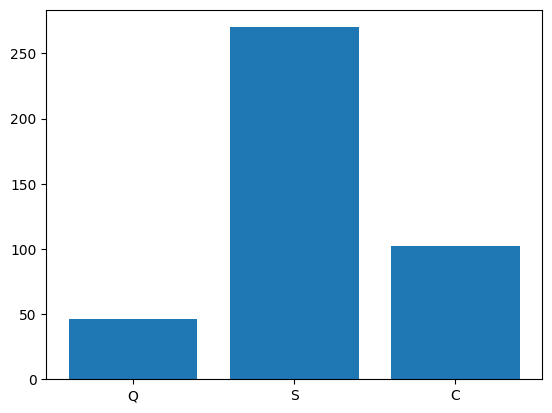

In [63]:
plt.bar(df['Embarked'].unique(), df["Embarked"].value_counts(sort=False))

#### Target variable: Survived
We just have a look at the distribution of the target variable 'Survived'. Our dataset is not unbalanced.  
Then we convert the variable into a categorical variable.

In [65]:
# among all passengers 38.38% survive
df['Survived'].mean()

In [ ]:
# change datatype from integer to object
df['Survived'] = df['Survived'].astype(object)

<AxesSubplot: >

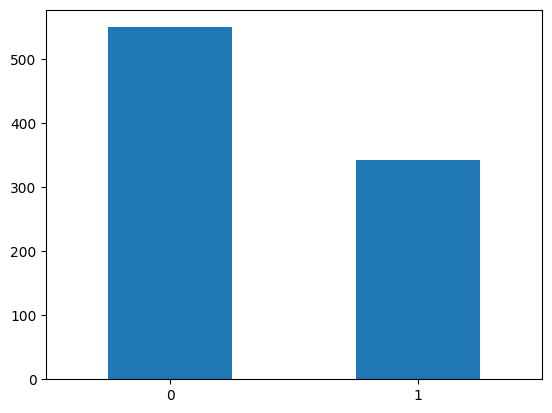

In [ ]:
df['Survived'].value_counts().plot(kind='bar', rot = 0)

In [66]:
df_full = df.copy()

### Correlations

#### Dataframe for correlations

In [67]:
# we drop 'Age_Opt2' and 'AgeGroup_Opt2'
df.drop("Age_Opt2", inplace=True, axis=1)
df.drop("AgeGroup_Opt2", inplace=True, axis=1)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    object 
 1   Sex         418 non-null    object 
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        417 non-null    float64
 6   Embarked    418 non-null    object 
 7   Title       418 non-null    object 
 8   Age_true    418 non-null    bool   
 9   AgeGroup    418 non-null    object 
 10  Familysize  418 non-null    int64  
 11  Ticketsize  418 non-null    int64  
 12  FareGroup   417 non-null    object 
 13  CabinLvl    418 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(7)
memory usage: 43.0+ KB


In [69]:
df_correlation = df.copy()

#### Correlation matrix

It's possible that the following cells don't work. If I run it locally (with Anaconda) it works, but in Visual Studio Code it doesn't. I'll try to fix it at some point. Till then, you can just have a look at the png file "complete_correlation" which I uploaded.

TypeError: Image data of dtype object cannot be converted to float

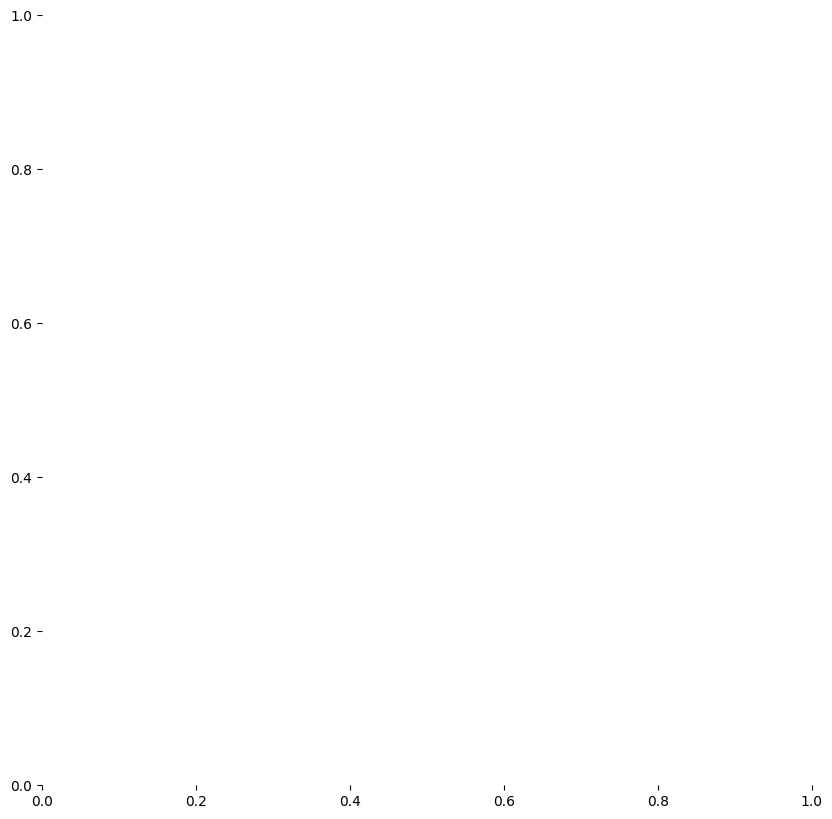

In [70]:
# correlation matrix (heatmap) for all features

from dython.nominal import associations

complete_correlation = associations(df, filename = 'complete_correlation', figsize=(10,10))
# put filename= 'complete_correlation.png' as parameter in associations to save the matrix as png

In [71]:
# correlation matrix of complete data set
df_complete_corr = complete_correlation['corr']
df_complete_corr.style.background_gradient(cmap='coolwarm', axis = None)

NameError: name 'complete_correlation' is not defined

In [ ]:
# correlation matrix for numerical variables
#corr_num = df.corr()
#corr_num.style.background_gradient(cmap='coolwarm')

#import seaborn as sns
#sns.heatmap(corr_num, annot = True)

#### Results from Correlation matrix
- Correlation with target variable 'Survived'
    * high correlation: 'Pclass', 'Sex', 'Fare', 'Title', 'FareGroup', 'CabinLvl'
    * normal correlation: 'Embarked', 'Age_true', 'AgeGroup'
    * low correlaton: 'Age', 'SibSp', 'Parch', 'Familysize', 'Ticketsize'
- Decisions based on correlation with 'Survived'
    * we drop the variable 'Ticketsize' due to its very low correlation with 'Survived'
    * we drop the variable 'Familysize' due to its very low correlation with 'Survived' and the high correlations with 'SibSp' and 'Parch'
    * we keep 'SibSp' and 'Parch' for now, but we will also train the models on a data set that doesn't contain those variables due to their very low correlation with 'Survived'
- High correlations between different variables (not considering 'SibSp', 'Parch', 'Familysize', and 'Ticketsize')
    * 'Sex' and 'Title' (0.99)
    * 'Pclass' and 'FareGroup' (0.77)
    * 'Pclass' and 'CabinLvl' (0.77)
    * 'Age' and 'Title' (0.57)
    * 'Age' and 'AgeGroup' (0.97)
    * 'Fare' and 'FareGroup' (0.87)
    * 'Fare' and 'CabinLvl' (0.59)
    * 'Title' and 'AgeGroup' (0.44)
    * 'Pclass' and 'Age' (-0.35)
    * 'Pclass' and 'Fare' (-0.57)
- Decisions based on high correlations between different variables
    * we drop one out of 'Sex' and 'Title' -> we keep 'Title' since it is more detailed and has a higher correlation with 'Survived' (0.57 vs. 0.54)
    * we drop one out of 'Age' and 'AgeGroup' since they strictly depend on each other -> we keep 'AgeGroup' since its correlation with 'Survived' is higher (0.18 vs.-0.09)
    * we drop one out of 'Fare' and 'FareGroup' since they strictly depend on each other -> we keep 'FareGroup' since its correlation with 'Survived' is higher (0.32 vs. 0.25)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    object 
 1   Sex         418 non-null    object 
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        417 non-null    float64
 6   Embarked    418 non-null    object 
 7   Title       418 non-null    object 
 8   Age_true    418 non-null    bool   
 9   AgeGroup    418 non-null    object 
 10  Familysize  418 non-null    int64  
 11  Ticketsize  418 non-null    int64  
 12  FareGroup   417 non-null    object 
 13  CabinLvl    418 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(7)
memory usage: 43.0+ KB


## Final Dataframe (without Encoding)
- Dropped variables: 'PassengerId', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', ('Familysize',) ('Ticketsize')
- New variables: ('Familysize',) ('Ticketsize',) 'Title', 'Age_true', 'AgeGroup', 'FareGroup', 'CabinLvl'
- Features in the final dataframe: 'Survived', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Title', 'Age_true', 'AgeGroup', 'FareGroup', 'CabinLvL'

In [73]:
dropped = ['Sex', 'Age', 'Fare', 'Familysize', 'Ticketsize']
#dropped = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Familysize', 'Ticketsize']
df.drop(dropped, inplace=True, axis=1)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pclass     418 non-null    object
 1   SibSp      418 non-null    int64 
 2   Parch      418 non-null    int64 
 3   Embarked   418 non-null    object
 4   Title      418 non-null    object
 5   Age_true   418 non-null    bool  
 6   AgeGroup   418 non-null    object
 7   FareGroup  417 non-null    object
 8   CabinLvl   418 non-null    object
dtypes: bool(1), int64(2), object(6)
memory usage: 26.7+ KB


In [75]:
# save dataframe

from datetime import datetime

# save data with date to track changes 
date = str(datetime.now().date()).replace("-", "")

df.to_csv(f"data/test_preprocessed_without_encoding_{date}.csv")

## Encoding
If we only keep the mentioned features, we don't need normalization (since we don't have any numerical features left).  
We use Ordinal Encoding (OrdinalEncoder from sklearn) for features that have an order or rank: 'Embarked', 'Age_true', 'AgeGroup', 'FareGroup'.
We use One-Hot-Encoding (OneHotEncoder form sklearn) for features that don't have an order or rank: 'Title', 'CabinLvl'.

In [79]:
# read dataframe

from datetime import datetime
import os

files = sorted([f for f in os.listdir("data") if (f.endswith(".csv") and (f.startswith("test_preprocessed_without_encoding")))], reverse=True)
latest = files[0]
df = pd.read_csv(f"data/{latest}")

# drop new generated index column
df.drop(df.columns[0], axis=1, inplace=True)
df_save = df.copy()

In [80]:
df["FareGroup"][152] = "Cheap"

/var/folders/yh/_hhnyz8x39x108l45f3_k0x40000gn/T/ipykernel_35531/1735944496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FareGroup"][152] = "Cheap"


### Ordinal Encoding

In [81]:
from sklearn.preprocessing import OrdinalEncoder

# 'Age_true'
ordinal_encoder1 = OrdinalEncoder()
# reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object
df['Age_true'] = ordinal_encoder1.fit_transform(df['Age_true'].values.reshape(-1,1))

# 'AgeGroup'
ordinal_encoder2 = OrdinalEncoder(categories = [['Kids', 'Teenagers', 'Young Adults', 'Adults', 'Middle-aged', 'Seniors']])
# reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object
df['AgeGroup'] = ordinal_encoder2.fit_transform(df['AgeGroup'].values.reshape(-1,1))

# 'FareGroup'
ordinal_encoder3 = OrdinalEncoder(categories = [['Very Cheap', 'Cheap', 'Normal', 'Average', 'Expensive', 'Very Expensive']])
# reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object
df['FareGroup'] = ordinal_encoder3.fit_transform(df['FareGroup'].values.reshape(-1,1))

# 'CabinLvl'
ordinal_encoder4 = OrdinalEncoder(categories = [['XX', 'G', 'F', 'E', 'D', 'C', 'B', 'A', 'T']])
# reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object
df['CabinLvl'] = ordinal_encoder4.fit_transform(df['CabinLvl'].values.reshape(-1,1))

# https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/# 

### One-Hot-Encoding

In [82]:
from sklearn.preprocessing import OneHotEncoder

# 'Embarked', 'Title'
onehot_encoder = OneHotEncoder()
# reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object
X_OneHot = onehot_encoder.fit_transform(df[['Embarked', 'Title']].values).toarray()
# add this back to the original dataframe
df_OneHot = pd.DataFrame(X_OneHot, columns = onehot_encoder.get_feature_names_out(['Embarked', 'Title']))
df = pd.concat([df, df_OneHot], axis=1)
df.drop(['Embarked', 'Title'], axis=1, inplace=True)

# we can consider also dropping 'Embarked_C' and 'Title_Mr' (to avoid multicollinearity), but for our classification models it shouldn't be necessary
#df.drop(['Embarked_C', 'Title_Mr'], axis=1, inplace=True)

# https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/# 
# if we apply One-Hot-Encoding for one column only: X_OneHot = onehot_encoder.fit_transform(df['Title'].values.reshape(-1,1)).toarray()

In [83]:
df.head()

,Pclass,SibSp,Parch,Age_true,AgeGroup,FareGroup,CabinLvl,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Noble
0,3,0,0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3,1,0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,0,0,1.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,0,0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,3,1,1,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [84]:
# Explanation why we could drop 'Title_Mr'
# see https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/ - Challenges of One-Hot Encoding: Dummy Variable Trap

import statsmodels.regression.linear_model as sm

def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X1 = df.drop(['Survived'],axis=1)
print(calculate_vif(X1))

X2 = df.drop(['Survived', 'Embarked_C'],axis=1)
print('\n', calculate_vif(X2))

X3 = df.drop(['Survived', 'Embarked_C', 'Title_Mr'],axis=1)
print('\n', calculate_vif(X3))

# Vif for 'Embarked_C' >> 5 -> drop it
# Vif for 'Title_Mr' >> 5 -> drop it

KeyError: "['Survived'] not found in axis"

# Final Dataframe

In [85]:
# change datatypes from float to int
df = df.astype(int)
df

,Pclass,SibSp,Parch,Age_true,AgeGroup,FareGroup,CabinLvl,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Noble
0,3,0,0,0,3,1,0,0,1,0,0,1,0,0,0
1,3,1,0,1,4,0,0,0,0,1,0,0,1,0,0
2,2,0,0,1,5,1,0,0,1,0,0,1,0,0,0
3,3,0,0,1,3,1,0,0,0,1,0,1,0,0,0
4,3,1,1,1,2,2,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,3,1,0,0,0,1,0,1,0,0,0
414,1,0,0,1,4,5,5,1,0,0,0,0,0,1,0
415,3,0,0,0,4,0,0,0,0,1,0,1,0,0,0
416,3,0,0,0,3,1,0,0,0,1,0,1,0,0,0


In [86]:
# save dataframe

from datetime import datetime

# save data with date to track changes 
date = str(datetime.now().date()).replace("-", "")

df.to_csv(f"data/test_preprocessed_{date}.csv")

# Train-Test-Split

In [87]:
# read dataframe

from datetime import datetime
import os

files = sorted([f for f in os.listdir("data") if (f.endswith(".csv") and (f.startswith("test_preprocessed_2")))], reverse=True)
latest = files[0]
df = pd.read_csv(f"data/{latest}")

# drop new generated index column
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Pclass,SibSp,Parch,Age_true,AgeGroup,FareGroup,CabinLvl,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Noble
0,3,0,0,0,3,1,0,0,1,0,0,1,0,0,0
1,3,1,0,1,4,0,0,0,0,1,0,0,1,0,0
2,2,0,0,1,5,1,0,0,1,0,0,1,0,0,0
3,3,0,0,1,3,1,0,0,0,1,0,1,0,0,0
4,3,1,1,1,2,2,0,0,0,1,0,0,1,0,0


In [88]:
y = df["Survived"]
X = df.drop("Survived", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

KeyError: 'Survived'

In [ ]:
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

In [ ]:
# save train and test data

from datetime import datetime

# save data with date to track changes 
date = str(datetime.now().date()).replace("-", "")

train_data.to_csv(f"data/train_data_{date}.csv")
test_data.to_csv(f"data/test_data_{date}.csv")

# First Models

In [ ]:
# read train and test data

from datetime import datetime
import os

# train_data
train_data_files = sorted([f for f in os.listdir("data") if (f.endswith(".csv") and (f.startswith("train_data_")))], reverse=True)
latest_train_data = train_data_files[0]
train_data = pd.read_csv(f"data/{latest_train_data}")

# drop new generated index column
train_data.drop(train_data.columns[0], axis=1, inplace=True)
display(train_data.head())

# split train_data for models
y_train = train_data['Survived']
X_train = train_data.drop('Survived', axis=1)


# test_data
test_data_files = sorted([f for f in os.listdir("data") if (f.endswith(".csv") and (f.startswith("test_data_")))], reverse=True)
latest_test_data = test_data_files[0]
test_data = pd.read_csv(f"data/{latest_test_data}")

#drop new generated index column
test_data.drop(test_data.columns[0], axis=1, inplace=True)
display(test_data.head())

# split test_data for models
y_test = test_data['Survived']
X_test = test_data.drop('Survived', axis=1)

,Pclass,SibSp,Parch,Age_true,AgeGroup,FareGroup,CabinLvl,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Noble,Survived
0,1,0,2,1,0,4,7,0,0,1,1,0,0,0,0,1
1,3,0,0,0,3,1,0,0,0,1,0,1,0,0,0,0
2,3,1,1,1,0,2,0,0,0,1,0,0,0,1,0,1
3,2,1,2,1,4,3,0,0,0,1,0,1,0,0,0,0
4,2,1,1,1,4,3,0,0,0,1,0,1,0,0,0,0


,Pclass,SibSp,Parch,Age_true,AgeGroup,FareGroup,CabinLvl,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Noble,Survived
0,3,1,1,0,0,2,0,1,0,0,1,0,0,0,0,1
1,2,0,0,1,3,1,0,0,0,1,0,1,0,0,0,0
2,3,0,0,1,2,1,0,0,0,1,0,1,0,0,0,0
3,2,0,1,1,0,3,0,0,0,1,0,0,0,1,0,1
4,3,1,0,1,1,2,0,1,0,0,0,0,0,1,0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# just some quick application of rf, dt, and mlp

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_pred)

print(f"Accuracy of RF: {rf_accuracy}")
print(f"Accuracy of DT: {dt_accuracy}")
print(f"Accuracy of MLP: {mlp_accuracy}")

Accuracy of RF: 0.8022388059701493
Accuracy of DT: 0.7910447761194029
Accuracy of MLP: 0.8171641791044776


C:\Users\kikip\anaconda3\envs\dm1_hws22\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Tasks

- plots in general: add description of axes, title etc.


## Things to discuss

- What about columns that contain integers but are actually categorical variables, e.g., 'Pclass' and 'Title' and the target variable 'Survived'
    * we convert them to categorical for the plots, for our final dataset we keep them as numeric
- NaNs in column Age: We have two options for replacing the NaNs in the column 'Age'
    * Option 1: replacing by an exact age:  
    for each category in 'Title', find the mean age, then assign this mean to the passengers without age;  
    assign the age groups afterwards
    * Option 2: replacing by an age group:  
    for each category in 'Title', find the age group that is represented most often, then assign this group to the passenger;  
    if we still need the "exact age", we can assign the mean age of the corresponding age group
    * we use Option 1 but keep the second option for the report